## 프로젝트: SentencePiece 사용하기

In [24]:
# 모듈 불러오기
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


In [74]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


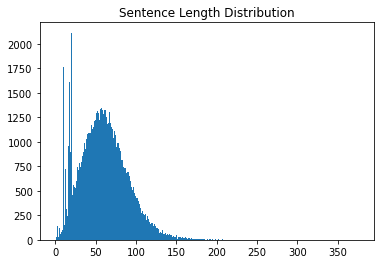

In [75]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: 
        min_len = length
    if max_len < length: 
        max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [76]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

# 이상치 확인하기
check_sentence_with_length(raw, 1)

’


In [77]:
# outlier 추출
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


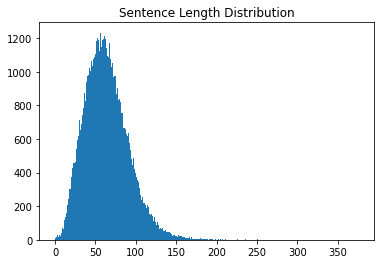

In [78]:
min_len = 999
max_len = 0
sum_len = 0

# 특정 길이 제거
cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

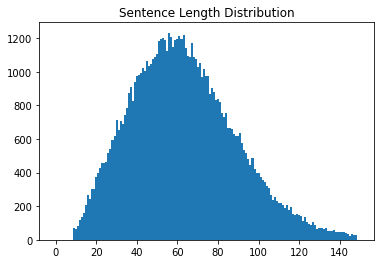

In [79]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [80]:
split_corpus = []

# 공백 추출 방식
for kor in filtered_corpus:
    split_corpus.append(kor.split())

In [25]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)
    
    # padding
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer


In [81]:
# SentencePiece unigram
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

# 정제한 corpus를 가지고 temp file에 write
with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 376816 Dec 27 03:27 korean_spm.model
-rw-r--r-- 1 root root 146213 Dec 27 03:27 korean_spm.vocab


In [143]:
# SentencePiece bpe
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

# 정제한 corpus를 가지고 temp file에 write
with open(temp_file, 'w') as f:
    for row in filtered_corpus: 
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_bpe --vocab_size={} --model_type=bpe'.format(temp_file, vocab_size)
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm_bpe*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm_bpe --vocab_size=8000 --model_type=bpe
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm_bpe
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_

-rw-r--r-- 1 root root 371940 Dec 27 05:48 korean_spm_bpe.model
-rw-r--r-- 1 root root 117142 Dec 27 05:48 korean_spm_bpe.vocab


### Ready for Data

In [19]:
!unzip nsmc-master.zip -d data

Archive:  nsmc-master.zip
cc0670e872d4ac27bfe36c87456783004b39ef6c
   creating: data/nsmc-master/
  inflating: data/nsmc-master/README.md  
   creating: data/nsmc-master/code/
  inflating: data/nsmc-master/code/crawl_ratings.py  
  inflating: data/nsmc-master/code/partition.py  
  inflating: data/nsmc-master/ratings.txt  
  inflating: data/nsmc-master/ratings_test.txt  
  inflating: data/nsmc-master/ratings_train.txt  
   creating: data/nsmc-master/raw/
  inflating: data/nsmc-master/raw/10001.json  
  inflating: data/nsmc-master/raw/100015.json  
  inflating: data/nsmc-master/raw/10002.json  
  inflating: data/nsmc-master/raw/100021.json  
  inflating: data/nsmc-master/raw/100022.json  
  inflating: data/nsmc-master/raw/100023.json  
  inflating: data/nsmc-master/raw/100026.json  
  inflating: data/nsmc-master/raw/10003.json  
  inflating: data/nsmc-master/raw/100039.json  
  inflating: data/nsmc-master/raw/10004.json  
  inflating: data/nsmc-master/raw/100041.json  
  inflating: data/

In [171]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/data/nsmc-master/ratings_train.txt')
test_data = pd.read_table('~/aiffel/data/nsmc-master/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### Load Data function

In [172]:
# data loader
# 데이터 중복 제거, NaN 결측치 제거, 한국어 토크나이저 토큰화, 불용어 제거
# 사전 word_to_index 구성
# x_train, y_train, x_test, y_test, word_to_index 리턴
from collections import Counter
from konlpy.tag import Mecab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

    
# konlpy tokenizer
# tokenizer = Mecab()
# 불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 데이터 불러오는 함수
def load_data(train_data, test_data, num_words=10000, tokenizer=Mecab()):
    # 중복 제거 및 Nan값 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # 토콘화 및 불용어 제거 - 이부분만 sentence piece로 바뀌면 되는거 아닌가요
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.pos(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.pos(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # X_train을 list로 만들어서 word에 들어 있는 text를 하나로 합친다
    words = [word for sublist in X_train for word in sublist]
    
    # Counter로 가장 빈도가 높은 단어 추출 10000-4만큼 (용어, count(용어))
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    # 빈도 높은 단어로 word index 사전 만들기
    word_to_index = {word:index for index, word in enumerate(vocab)}
     
    # word 리스트를 인자로 받았을 때 index리스트로 변환해줌    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    # X_train. y_train, X_test , y_test
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    

In [173]:
# 모든 문장은 Bos로 시작
# 단어 인덱스 리스트로 변환해주는 함수
def get_encoded_sentence(sentence,word_to_index):
    return [word_to_indexp['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentences.split() ]


# 여러 문장 리스트를 한번에 encode
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence,word_to_index) for sentence in sentences]
# 변수에 담아서 출력하면 [[list 형태의 문장 index가  출력됨]]

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded in encoded_sentences]


# 앞문장 BoS는 제거해주고, index가 index_to word에 없으면 Unkown으로 처리
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:

### Train,Test data, word2index

In [174]:
# Hannanum
from konlpy.tag import Hannanum
# Kkma
from konlpy.tag import Kkma
# Komoran
from konlpy.tag import Komoran
# Mecab
from konlpy.tag import Mecab
from konlpy.tag import Okt


tokenizer_list = [Hannanum(),Kkma(),Komoran(),Mecab(),Okt()]

# 데이터 load_data함수 사용해서 train, test, 데이터 만들기
X_train_h, y_train_h, X_test_h, y_test_h, word_to_index_h = load_data(train_data, test_data,
                                                            tokenizer_list[0])
X_train_K, y_train_K, X_test_K, y_test_K, word_to_index_K = load_data(train_data, test_data,
                                                            tokenizer_list[1])
X_train_komo, y_train_komo, X_test_komo, y_test_komo, word_to_index_komo = load_data(train_data, test_data,
                                                            tokenizer_list[2])
X_train_Me, y_train_Me, X_test_Me, y_test_Me, word_to_index_Me = load_data(train_data, test_data,
                                                            tokenizer_list[3])
X_train_Ok, y_train_Ok, X_test_Ok, y_test_Ok, word_to_index_Ok = load_data(train_data, test_data,
                                                            tokenizer_list[4])


In [175]:
def word_to_index(word_to_index):
    # 실제 인코딩 인덱스는 제공된 word_to_index 기준으로 3씩 뒤로 밀려 있다
    word_to_index ={k:(v+3) for k,v in word_to_index.items()}

    # Hannanum
    # 처음 몇개의 인덱스는 사전 정의
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2
    word_to_index["<UNUSED>"] = 3
    index_to_word = {index:word for word, index in word_to_index.items()}
    
    return word_to_index, index_to_word


# Hannanum
word_to_index_h,index_to_word_h = word_to_index(word_to_index_h)
#Okt
word_to_index_Ok,index_to_word_Ok = word_to_index(word_to_index_Ok)
#KKma
word_to_index_K,index_to_word_K = word_to_index(word_to_index_K)
#Komoran 
word_to_index_komo,index_to_word_komo = word_to_index(word_to_index_komo)
#Mecab 
word_to_index_Me,index_to_word_Me = word_to_index(word_to_index_Me)



### Hannanum, Kkma, Komoran, Mecab, Okt 

In [176]:
# maxlen 
def set_max_len(X_train,X_test,tokenizer_name):
    total_data_text = list(X_train) + list(X_test)
    # 텍스트데이터 문장길이의 리스트를 생성한 후
    num_tokens = [len(tokens) for tokens in total_data_text]
    num_tokens = np.array(num_tokens)
    # 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
    
    print("===========================================================================")
    print(tokenizer_name)
    print('문장길이 평균 : ', np.mean(num_tokens))
    print('문장길이 최대 : ', np.max(num_tokens))
    print('문장길이 표준편차 : ', np.std(num_tokens))

    # 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
    max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    print('pad_sequences maxlen : ', maxlen)
    print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다.')
    
    return maxlen


maxlen = set_max_len(X_train_h,X_test_h,"Hannanum")
maxlen_k = set_max_len(X_train_K,X_test_K,"Kkma")
maxlen_komo = set_max_len(X_train_komo,X_test_komo,"Komoran")
maxlen_Me = set_max_len(X_train_Me,X_test_Me,"Mecab")
maxlen_Ok = set_max_len(X_train_Ok,X_test_Ok,"Okt")



Hannanum
문장길이 평균 :  18.72297390690031
문장길이 최대 :  116
문장길이 표준편차 :  15.329503337998032
pad_sequences maxlen :  49
전체 문장의 0.9346725436292804%가 maxlen 설정값 이내에 포함됩니다.
Kkma
문장길이 평균 :  18.72297390690031
문장길이 최대 :  116
문장길이 표준편차 :  15.329503337998032
pad_sequences maxlen :  49
전체 문장의 0.9346725436292804%가 maxlen 설정값 이내에 포함됩니다.
Komoran
문장길이 평균 :  18.72297390690031
문장길이 최대 :  116
문장길이 표준편차 :  15.329503337998032
pad_sequences maxlen :  49
전체 문장의 0.9346725436292804%가 maxlen 설정값 이내에 포함됩니다.
Mecab
문장길이 평균 :  18.72297390690031
문장길이 최대 :  116
문장길이 표준편차 :  15.329503337998032
pad_sequences maxlen :  49
전체 문장의 0.9346725436292804%가 maxlen 설정값 이내에 포함됩니다.
Okt
문장길이 평균 :  18.72297390690031
문장길이 최대 :  116
문장길이 표준편차 :  15.329503337998032
pad_sequences maxlen :  49
전체 문장의 0.9346725436292804%가 maxlen 설정값 이내에 포함됩니다.


In [177]:
# padding 처리
import tensorflow as tf

def padding_data(X_train,X_test,maxlen):
    x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                            value=word_to_index_h["<PAD>"],
                                                            padding='post', # 혹은 'pre'
                                                            maxlen=maxlen)

    x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                           value=word_to_index_h["<PAD>"],
                                                           padding='post', # 혹은 'pre'
                                                           maxlen=maxlen)
    return x_train, x_test
    

# paddding은 post로 진행
x_train_h, x_test_h = padding_data(X_train_h, X_test_h,maxlen)
x_train_K, x_test_K = padding_data(X_train_K, X_test_K,maxlen_k)
x_train_komo, x_test_komo = padding_data(X_train_komo, X_test_komo,maxlen_komo)
x_train_Ok, x_test_Ok = padding_data(X_train_Ok, X_test_Ok,maxlen_Ok)
x_train_Me, x_test_Me = padding_data(X_train_Me, X_test_Me,maxlen_Me)

print(x_train_h.shape)
print(x_train_K.shape)
print(x_train_komo.shape)
print(x_train_Ok.shape)
print(x_train_Me.shape)

(146182, 49)
(146182, 49)
(146182, 49)
(146182, 49)
(146182, 49)


### LSTM Model

In [178]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

class BiLSTMModel(tf.keras.Model):
    def __init__(self, vocab_size, word_vector_dim):
        super(BiLSTMModel, self).__init__()
        

        self.embedding_layer = tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
        self.lstm_layer1 = tf.keras.layers.LSTM(128, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)
        self.lstm_layer2 = tf.keras.layers.LSTM(128, dropout=0.5)
        self.dense_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.embedding_layer(inputs)
        x = self.lstm_layer1(x)
        x = self.lstm_layer2(x)
        outputs = self.dense_layer(x)
        return outputs

# Create an instance of the BiLSTMModel
vocab_size = 10000
word_vector_dim = 250

model_h = BiLSTMModel(vocab_size, word_vector_dim)
model_Me = BiLSTMModel(vocab_size, word_vector_dim)
model_Ok = BiLSTMModel(vocab_size, word_vector_dim)
model_K = BiLSTMModel(vocab_size, word_vector_dim)
model_komo = BiLSTMModel(vocab_size, word_vector_dim)





[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 훈련 데이터 만들기

In [179]:
# hannanum
# validation set 10000건 분리
x_val_h = x_train_h[:26182]   
y_val_h = y_train_h[:26182]

# validation set을 제외한 나머지 15000건
partial_x_train_h = x_train_h[26182:]  
partial_y_train_h = y_train_h[26182:]

print("hannanum")
print(partial_x_train_h.shape)
print(partial_y_train_h.shape)

# OKt
# validation set 10000건 분리
x_val_Ok = x_train_Ok[:26182]   
y_val_Ok = y_train_Ok[:26182]

# validation set을 제외한 나머지 15000건
partial_x_train_Ok = x_train_Ok[26182:]  
partial_y_train_Ok = y_train_Ok[26182:]

print("Okt")
print(partial_x_train_Ok.shape)
print(partial_y_train_Ok.shape)


# Komoran
# validation set 10000건 분리
x_val_komo = x_train_komo[:26182]   
y_val_komo = y_train_komo[:26182]

# validation set을 제외한 나머지 15000건
partial_x_train_komo = x_train_komo[26182:]  
partial_y_train_komo = y_train_komo[26182:]


print("Komoran")
print(partial_x_train_komo.shape)
print(partial_y_train_komo.shape)



# Mecab
# validation set 10000건 분리
x_val_Me = x_train_Me[:26182]   
y_val_Me = y_train_Me[:26182]

# validation set을 제외한 나머지 15000건
partial_x_train_Me = x_train_Me[26182:]  
partial_y_train_Me = y_train_Me[26182:]
print("Mecab")
print(partial_x_train_Me.shape)
print(partial_y_train_Me.shape)

# Kkma
# validation set 10000건 분리
x_val_K = x_train_K[:26182]   
y_val_K = y_train_K[:26182]

# validation set을 제외한 나머지 15000건
partial_x_train_K = x_train_K[26182:]  
partial_y_train_K = y_train_K[26182:]

print("kkma")
print(partial_x_train_K.shape)
print(partial_y_train_K.shape)

hannanum
(120000, 49)
(120000,)
Okt
(120000, 49)
(120000,)
Komoran
(120000, 49)
(120000,)
Mecab
(120000, 49)
(120000,)
kkma
(120000, 49)
(120000,)


### Training

In [180]:
# 최적화 함수 Adam, RMSprops
opt = tf.keras.optimizers.Adam()

# 손실함수 binary_crossentropy 사용
model_h.compile(optimizer=opt, # 'adam'
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 손실함수 binary_crossentropy 사용
model_Me.compile(optimizer=opt, # 'adam'
              loss='binary_crossentropy',
              metrics=['accuracy'])
# 손실함수 binary_crossentropy 사용
model_Ok.compile(optimizer=opt, # 'adam'
              loss='binary_crossentropy',
              metrics=['accuracy'])
# 손실함수 binary_crossentropy 사용
model_K.compile(optimizer=opt, # 'adam'
              loss='binary_crossentropy',
              metrics=['accuracy'])
# 손실함수 binary_crossentropy 사용
model_komo.compile(optimizer=opt, # 'adam'
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [181]:
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

#hannanum
history_h = model_h.fit(partial_x_train_h,
                    partial_y_train_h,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val_h, y_val_h),
                    verbose=1)
#Mecab
history_Me = model_Me.fit(partial_x_train_Me,
                    partial_y_train_Me,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val_Me, y_val_Me),
                    verbose=1)
#OKt
history_Ok = model_Ok.fit(partial_x_train_Ok,
                    partial_y_train_Ok,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val_Ok, y_val_Ok),
                    verbose=1)
#Kkma
history_k = model_K.fit(partial_x_train_K,
                    partial_y_train_K,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val_K, y_val_K),
                    verbose=1)
# komoran
history_komo = model_komo.fit(partial_x_train_komo,
                    partial_y_train_komo,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val_komo, y_val_komo),
                    verbose=1)

Epoch 1/5
235/235 [==============================] - 54s 217ms/step - loss: 0.4722 - accuracy: 0.7458 - val_loss: 0.3557 - val_accuracy: 0.8455
Epoch 2/5
235/235 [==============================] - 50s 214ms/step - loss: 0.3257 - accuracy: 0.8608 - val_loss: 0.3309 - val_accuracy: 0.8569
Epoch 3/5
235/235 [==============================] - 50s 213ms/step - loss: 0.2911 - accuracy: 0.8770 - val_loss: 0.3539 - val_accuracy: 0.8548
Epoch 4/5
235/235 [==============================] - 50s 213ms/step - loss: 0.2606 - accuracy: 0.8904 - val_loss: 0.3240 - val_accuracy: 0.8628
Epoch 5/5
235/235 [==============================] - 50s 214ms/step - loss: 0.2391 - accuracy: 0.9012 - val_loss: 0.3701 - val_accuracy: 0.8582
Epoch 1/5
235/235 [==============================] - 55s 218ms/step - loss: 0.5235 - accuracy: 0.7103 - val_loss: 0.3781 - val_accuracy: 0.8389
Epoch 2/5
235/235 [==============================] - 51s 216ms/step - loss: 0.3271 - accuracy: 0.8622 - val_loss: 0.3244 - val_accuracy:

### Various Tokenizer Training Result

In [182]:
history_dict_h = history_h.history
history_dict_k = history_k.history
history_dict_me = history_Me.history
history_dict_komo = history_komo.history
history_dict_ok = history_Ok.history


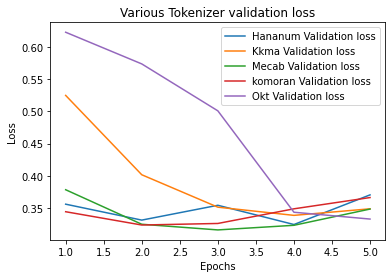

In [183]:
# 손실함수 그래프 확인
import matplotlib.pyplot as plt

#acc = history_dict['accuracy']
#val_acc = history_dict['val_accuracy']
#loss = history_dict['loss']
#val_loss = history_dict['val_loss']

epochs = range(1, 5 + 1)

# "bo"는 "파란색 점"입니다
#plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, history_dict_h['val_loss'],  label='Hananum Validation loss')
plt.plot(epochs, history_dict_k['val_loss'], label='Kkma Validation loss')
plt.plot(epochs, history_dict_me['val_loss'],  label='Mecab Validation loss')
plt.plot(epochs, history_dict_komo['val_loss'], label='komoran Validation loss')
plt.plot(epochs, history_dict_ok['val_loss'],  label='Okt Validation loss')

plt.title('Various Tokenizer validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

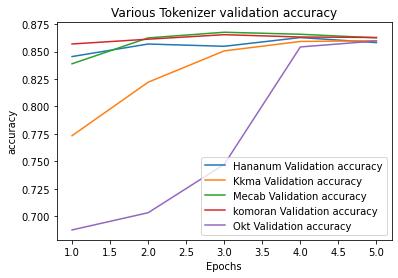

In [184]:
epochs = range(1,5+ 1)

# "bo"는 "파란색 점"입니다
#plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, history_dict_h['val_accuracy'],  label='Hananum Validation accuracy')
plt.plot(epochs, history_dict_k['val_accuracy'], label='Kkma Validation accuracy')
plt.plot(epochs, history_dict_me['val_accuracy'],  label='Mecab Validation accuracy')
plt.plot(epochs, history_dict_komo['val_accuracy'], label='komoran Validation accuracy')
plt.plot(epochs, history_dict_ok['val_accuracy'],  label='Okt Validation accuracy')

plt.title('Various Tokenizer validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

- 결과적으로 Kkma 가장 좋은 성능을 보였고, 그 다음으로 Mecab이 좋은 성능을 보였다
- accuracy는 Kkma이 조금 더 좋았으나 loss 값은 Mecab이 훨씬 낮게 나왔다.
- OKt가 가장 안좋은 성능을 보였다
- 아마도 okt로 tokenize한 값들이..... 모호했나..


### SentencePiece

In [102]:
def sp_tokenize(s, corpus): 

    tensor = []
    
    # corpus 문장 말뭉치 - 온전한 문장의 list 전달
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})
    
    # padding 처리
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen = 47)

    return tensor, word_index, index_word

In [103]:
# sentencePiece Unigram Mode

s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [145]:
# sentencePiece Bpe Mode

s_bpe = spm.SentencePieceProcessor()
s_bpe.Load('korean_spm_bpe.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s_bpe.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_bpe.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_bpe.DecodeIds(tokensIDs))

[1520, 1154, 6614, 6710, 2644, 6782, 6685, 6687]
['▁아버', '지가', '방에', '들', '어가', '신', '다', '.']
아버지가방에들어가신다.


- Bpe보다 unigram이 의미가 있는 작은 단어로 더 잘 쪼개진 것으로 보인다

In [104]:
train_data = pd.read_table('~/aiffel/data/nsmc-master/ratings.txt')
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [105]:
from sklearn.model_selection import train_test_split

# 데이터 불러오는 함수
def load_data(train_data, s ):
    # 중복 제거 및 NaN값 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')

    # SentencePiece Tokenization
    X_train, word_index, index_word = sp_tokenize(s, train_data['document'])
    X_train, X_val, y_train, y_val = train_test_split(X_train, train_data['label'], test_size=0.2, random_state=42)

    # X_train, y_train, X_test, y_test
    return X_train, X_val, y_train, y_val, word_index


In [135]:
len(X_train[0])

47

In [106]:
# unigram sentence piece tokenizer
X_train, X_val, y_train, y_val, word_to_index = load_data(train_data, s)

vocab_size = len(word_to_index)
# 250
word_vector_dim = 250
model = BiLSTMModel(vocab_size, word_vector_dim)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [147]:
# bpe sentence piece tokenizer
X_train, X_val, y_train, y_val, word_to_index = load_data(train_data, s_bpe)

vocab_size = len(word_to_index)
# 250
word_vector_dim = 250
model_bpe = BiLSTMModel(vocab_size, word_vector_dim)

model_bpe.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [107]:
# Train the model
epochs = 5
batch_size = 512
model.fit(np.array(X_train), y_train, 
          epochs=epochs, 
          batch_size=batch_size, 
          validation_data=(np.array(X_val), y_val))

Epoch 1/5
304/304 [==============================] - 71s 210ms/step - loss: 0.4648 - accuracy: 0.7714 - val_loss: 0.3977 - val_accuracy: 0.8187
Epoch 2/5
304/304 [==============================] - 62s 205ms/step - loss: 0.3824 - accuracy: 0.8277 - val_loss: 0.3745 - val_accuracy: 0.8333
Epoch 3/5
304/304 [==============================] - 62s 204ms/step - loss: 0.3463 - accuracy: 0.8461 - val_loss: 0.3749 - val_accuracy: 0.8371
Epoch 4/5
304/304 [==============================] - 62s 204ms/step - loss: 0.3212 - accuracy: 0.8605 - val_loss: 0.3540 - val_accuracy: 0.8375
Epoch 5/5
304/304 [==============================] - 62s 205ms/step - loss: 0.3024 - accuracy: 0.8711 - val_loss: 0.3557 - val_accuracy: 0.8414


In [131]:
results = model.evaluate(X_val,  y_val, verbose=2)
print(results)

1216/1216 - 17s - loss: 0.3557 - accuracy: 0.8414
[0.35566651821136475, 0.8414248824119568]


In [148]:
# Train the model
epochs = 5
batch_size = 512
history_bpe = model_bpe.fit(np.array(X_train), y_train, 
          epochs=epochs, 
          batch_size=batch_size, 
          validation_data=(np.array(X_val), y_val))

Epoch 1/5
304/304 [==============================] - 69s 210ms/step - loss: 0.4642 - accuracy: 0.7690 - val_loss: 0.4031 - val_accuracy: 0.8179
Epoch 2/5
304/304 [==============================] - 64s 209ms/step - loss: 0.3809 - accuracy: 0.8290 - val_loss: 0.3858 - val_accuracy: 0.8275
Epoch 3/5
304/304 [==============================] - 64s 209ms/step - loss: 0.3443 - accuracy: 0.8465 - val_loss: 0.3587 - val_accuracy: 0.8392
Epoch 4/5
304/304 [==============================] - 64s 209ms/step - loss: 0.3198 - accuracy: 0.8604 - val_loss: 0.3561 - val_accuracy: 0.8412
Epoch 5/5
304/304 [==============================] - 63s 208ms/step - loss: 0.2987 - accuracy: 0.8730 - val_loss: 0.3639 - val_accuracy: 0.8421


### Unigram & BPE Result

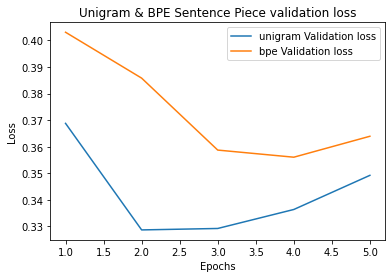

In [149]:
history_dict_bpe = history_bpe.history

# 손실함수 그래프 확인
import matplotlib.pyplot as plt

epochs = range(1, 5+ 1)

plt.plot(epochs, history_dict_s['val_loss'],  label='unigram Validation loss')
plt.plot(epochs, history_dict_bpe['val_loss'],  label='bpe Validation loss')

plt.title('Unigram & BPE Sentence Piece validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()


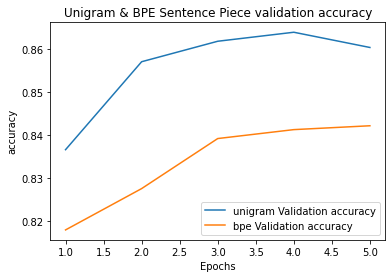

In [150]:
history_dict_bpe = history_bpe.history

# 손실함수 그래프 확인
import matplotlib.pyplot as plt

epochs = range(1, 5+ 1)

plt.plot(epochs, history_dict_s['val_accuracy'],  label='unigram Validation accuracy')
plt.plot(epochs, history_dict_bpe['val_accuracy'],  label='bpe Validation accuracy')

plt.title('Unigram & BPE Sentence Piece validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

plt.legend()

plt.show()


- unigram mode와 Bpe mode를 비교해보았을 때 큰 차이가 나지는 않지만 unigram이 더 성능이 좋게 나타났다.
- 앞에 쪼갠 문장을 확인해보았을 때 unigram이 bpe보다 의미를 잘 보존한 작은 단위로 더 잘 쪼개졌기 때문이것 같다.

### Tokenizer All

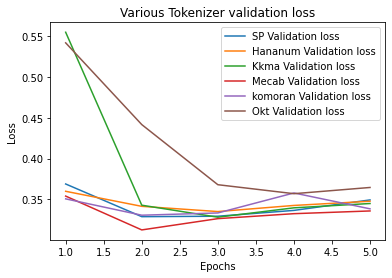

In [134]:

history_dict_s = history.history

# 손실함수 그래프 확인
import matplotlib.pyplot as plt

epochs = range(1, 5+ 1)

plt.plot(epochs, history_dict_s['val_loss'],  label='SP Validation loss')
plt.plot(epochs, history_dict_h['val_loss'],  label='Hananum Validation loss')
plt.plot(epochs, history_dict_k['val_loss'], label='Kkma Validation loss')
plt.plot(epochs, history_dict_me['val_loss'],  label='Mecab Validation loss')
plt.plot(epochs, history_dict_komo['val_loss'], label='komoran Validation loss')
plt.plot(epochs, history_dict_ok['val_loss'],  label='Okt Validation loss')

plt.title('Various Tokenizer validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

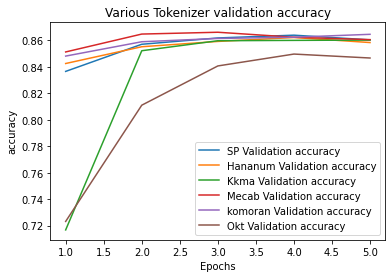

In [136]:
history_dict_s = history.history

# 손실함수 그래프 확인
import matplotlib.pyplot as plt

epochs = range(1, 5+ 1)

plt.plot(epochs, history_dict_s['val_accuracy'],  label='SP Validation accuracy')
plt.plot(epochs, history_dict_h['val_accuracy'],  label='Hananum Validation accuracy')
plt.plot(epochs, history_dict_k['val_accuracy'], label='Kkma Validation accuracy')
plt.plot(epochs, history_dict_me['val_accuracy'],  label='Mecab Validation accuracy')
plt.plot(epochs, history_dict_komo['val_accuracy'], label='komoran Validation accuracy')
plt.plot(epochs, history_dict_ok['val_accuracy'],  label='Okt Validation accuracy')

plt.title('Various Tokenizer validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

plt.legend()

plt.show()

- 결론적으로 sentencepiece를 사용한 모델의 성능이 더 높게 나타났다
- Tokenizer를 변경했을 뿐인데 성능이 크게는 4%까지 차이가 났다.
- 모델도 중요하지만 전처리하는 과정이 훨씬 더 많이 걸렸고, 언어라는 데이터 자체도 너무 모호해서 전처리하는 방식의 중요성을 배웠다..